# Feedforward Neural Network (from scratch)

# Data Loading and Preprocessing


In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the Diabetes dataset
data = load_diabetes()
X, y = data.data, data.target

# Normalize the target to binary classification
y = (y > np.median(y)).astype(int)

# Split the dataset into training (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [3]:
#training samples, test samples, validation samples, total samples
len(X_train), len(X_test), len(X_val), len(X)

(309, 67, 66, 442)

In [4]:
X_train.shape, y_train.shape

((309, 10), (309,))

# Neural Network Implementation

In [5]:
class FeedforwardNeuralNetwork:
    # input_size: number of input features, hidden_size: number of neurons in the hidden layer, output_size: number of output neurons
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases
        # W1: weights from input layer to hidden layer
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(input_size)
        # b1: bias for the hidden layer.
        self.b1 = np.zeros((1, hidden_size))
         # W2: weights from hidden layer to output layer,
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(hidden_size)
        # b2: output bias.
        self.b2 = np.zeros((1, output_size))

## ReLU activation function
# ReLU → used in hidden layers, Z = XW+B, X → input features
    def relu(self, Z):
        return np.maximum(0, Z)
# ReLU Derivative
    def relu_derivative(self, Z):
      #ReLU derivative → used during backpropagation
       # If Z > 0, derivative is 1, Otherwise, it is 0
        return Z > 0

# sigmoid activation function, Sigmoid → used in the output layer for binary classification
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

# forward pass defines how data flows through the network
    def forward(self, X):
        # Forward pass - compute predictions
        # compute a linear combination Z1, Z1 → pre-activation of hidden layer
        self.Z1 = np.dot(X, self.W1) + self.b1
        # apply ReLU to get hidden layer activations (A1), A1 → output of hidden layer after ReLU
        self.A1 = self.relu(self.Z1)
        # compute output layer values, Z2 → pre-activation of output layer,
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        # Apply sigmoid to get probabilities between 0 and 1, A2 → final prediction
        self.A2 = self.sigmoid(self.Z2)
        # returned value is the model’s prediction
        return self.A2

# Loss Function - computes how wrong our predictions are, measure error
    def compute_cost(self, Y_pred, Y):
        # Cross-entropy loss
        m = Y.shape[0] #m is the number of training samples in the batch
        cost = -np.sum(Y * np.log(Y_pred) + (1 - Y) * np.log(1 - Y_pred)) / m # binary cross-entropy loss
        return cost


    def backward(self, X, Y): # This method computes gradients
        m = X.shape[0] # m is batch size

        dZ2 = self.A2 - Y.reshape(-1,1) #error at the output layer, A2 → predicted output, Y → true labels
        # compute gradients for all neurons at once
        # self.A1.T → transpose to align dimensions
        self.dW2 = np.dot(self.A1.T, dZ2) / m # computes the gradient of loss with respect to W2
        self.db2 = np.sum(dZ2, axis=0, keepdims=True) / m # propagate error backward to the hidden layer

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        self.dW1 = np.dot(X.T, dZ1) / m # Gradient of loss with respect to W1
        self.db1 = np.sum(dZ1, axis=0, keepdims=True) / m #Bias gradients for the hidden layer

# Updating Parameters- changes the weights
    def update_parameters(self, learning_rate):
        self.W1 -= learning_rate * self.dW1
        self.b1 -= learning_rate * self.db1
        self.W2 -= learning_rate * self.dW2
        self.b2 -= learning_rate * self.db2

## Training Loop
    def train(self, X_train, Y_train, X_val, Y_val, epochs, learning_rate, batch_size):
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # Shuffle training data
            indices = np.arange(X_train.shape[0])
             # shuffle data each epoch so the model does not memorize order patterns
            np.random.shuffle(indices)
            X_train = X_train[indices]
            Y_train = Y_train[indices]

            # training
            train_loss = 0
            for i in range(0, X_train.shape[0], batch_size):
                end_idx = min(i + batch_size, X_train.shape[0])
                X_batch = X_train[i:end_idx]
                Y_batch = Y_train[i:end_idx]
                Y_pred = self.forward(X_batch) # Forward pass
                self.backward(X_batch, Y_batch) # Backpropagation
                self.update_parameters(learning_rate) # Parameter update
                train_loss += self.compute_cost(Y_pred, Y_batch)

            avg_train_loss = train_loss/(len(range(0, X_train.shape[0], batch_size)))
            train_losses.append(avg_train_loss)

            # validation loss
            val_loss = 0
            for i in range(0, X_val.shape[0], batch_size):
                end_idx = min(i + batch_size, X_val.shape[0])
                X_batch = X_val[i:end_idx]
                Y_batch = Y_val[i:end_idx]
                Y_pred = self.forward(X_batch)
                val_loss += self.compute_cost(Y_pred, Y_batch)

            avg_val_loss = val_loss/(len(range(0, X_val.shape[0], batch_size)))
            val_losses.append(avg_val_loss)

            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        return train_losses, val_losses

# Prediction Function - converts probabilities into class labels
    def predict(self, X):
        Y_pred = self.forward(X)
        # 0.5 → class 1, ≤ 0.5 → class 0
        return (Y_pred > 0.5).astype(int)

## Loss Plot Function - plots training and validation loss curves
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Model Training and Evaluation

C:\Users\shamb\AppData\Local\Temp\ipykernel_12664\4086536291.py:46: RuntimeWarning: divide by zero encountered in log
  cost = -np.sum(Y * np.log(Y_pred) + (1 - Y) * np.log(1 - Y_pred)) / m # binary cross-entropy loss
C:\Users\shamb\AppData\Local\Temp\ipykernel_12664\4086536291.py:46: RuntimeWarning: invalid value encountered in multiply
  cost = -np.sum(Y * np.log(Y_pred) + (1 - Y) * np.log(1 - Y_pred)) / m # binary cross-entropy loss


Epoch 1/100, Training Loss: nan, Validation Loss: nan
Epoch 11/100, Training Loss: 0.5736, Validation Loss: 0.7446
Epoch 21/100, Training Loss: 0.5820, Validation Loss: 0.6781
Epoch 31/100, Training Loss: 0.4768, Validation Loss: 0.7443
Epoch 41/100, Training Loss: 0.4431, Validation Loss: 0.6023
Epoch 51/100, Training Loss: 0.3973, Validation Loss: 0.5879
Epoch 61/100, Training Loss: 0.4074, Validation Loss: 0.6245
Epoch 71/100, Training Loss: 0.3855, Validation Loss: 0.6366
Epoch 81/100, Training Loss: 0.3773, Validation Loss: 0.5973
Epoch 91/100, Training Loss: 0.3616, Validation Loss: 0.6383


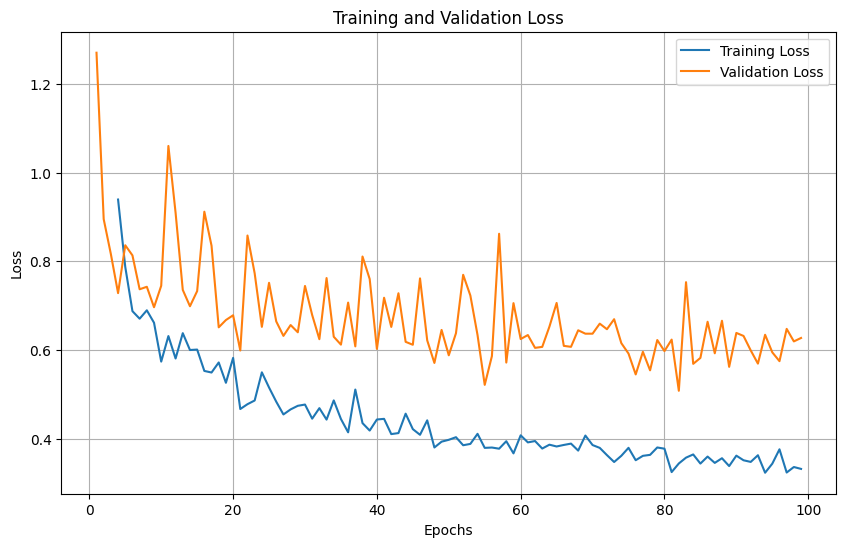

In [6]:
# Initialize and train the neural network
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1

y_train_reshaped = y_train.reshape(-1, 1)
y_val_reshaped = y_val.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

model = FeedforwardNeuralNetwork(input_size, hidden_size, output_size)

learning_rate = 0.1
batch_size = 10
epochs = 100

train_losses, val_losses = model.train(X_train, y_train_reshaped, X_val, y_val_reshaped, epochs, learning_rate, batch_size)

# Plot training loss
plot_loss(train_losses, val_losses)


# Save and Load Model Weights

In [7]:
# Save the model weights
np.savez("model_weights.npz", W1=model.W1, b1=model.b1, W2=model.W2, b2=model.b2)

# Load the saved weights
weights = np.load("model_weights.npz")
model_inference = FeedforwardNeuralNetwork(input_size, hidden_size, output_size)
model_inference.W1 = weights["W1"]
model_inference.b1 = weights["b1"]
model_inference.W2 = weights["W2"]
model_inference.b2 = weights["b2"]


# Performance Evaluation

In [8]:
# Perform prediction on the test set
y_pred = model_inference.predict(X_test) # X_test is the test input data

# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.6716
Precision: 0.6364
Recall: 0.6774


# Pytorch Implementation

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class PyTorchNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PyTorchNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # first fully connected layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): # forward() function defines the forward pass
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x # return final prediction

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_reshaped, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_reshaped, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_reshaped, dtype=torch.float32)


# Create data loaders for training
# TensorDataset wraps (X, y) together so each sample returns an input and its label
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
#DataLoader is an iterator that automatically: splits data into batches of size batch_size, optionally shuffles samples each epoch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



# Train the model
def train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0    # train_loss accumulates training loss across batches
        val_loss = 0   # val_loss accumulates validation loss across validation batches
        for X_batch, y_batch in train_loader:
            # Training
            optimizer.zero_grad() # This clears old gradients
            outputs = model(X_batch) # calls forward() and produces predicted probabilities
            loss = criterion(outputs, y_batch) #computes the loss between predictions and true labels
            loss.backward() # PyTorch computes gradients using backpropagation
            optimizer.step() # ‘learning’ step, updates the model parameters (weights and biases) using the computed gradients
            train_loss += loss.item()
            # Average training loss for the epoch
        avg_train_loss = train_loss/len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval() # switch the model to evaluation mode
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                val_outputs = model(X_batch) #Compute validation predictions
                val_loss += criterion(val_outputs, y_batch) # Compute validation loss
        avg_val_loss = val_loss/len(val_loader)
        val_losses.append(avg_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

# Initialize model and training parameters
pytorch_model = PyTorchNN(input_size, hidden_size, output_size)
criterion = nn.BCELoss() # Binary cross entropy loss
optimizer = optim.SGD(pytorch_model.parameters(), lr=learning_rate)

# Train the model
train_losses, val_losses = train_model(pytorch_model, criterion, optimizer, epochs, train_loader, val_loader)

# Save the trained model weights
# state_dict() is a dictionary containing all learnable parameters: weights and biases for each layer
# file 'pytorch_model_weights.pth' stores these parameters so we can reuse the model without retraining
torch.save(pytorch_model.state_dict(), 'pytorch_model_weights.pth')


Epoch [10/100], Train Loss: 0.6526, Val Loss: 0.6297
Epoch [20/100], Train Loss: 0.5949, Val Loss: 0.5359
Epoch [30/100], Train Loss: 0.5592, Val Loss: 0.4661
Epoch [40/100], Train Loss: 0.5409, Val Loss: 0.4437
Epoch [50/100], Train Loss: 0.5386, Val Loss: 0.4317
Epoch [60/100], Train Loss: 0.5190, Val Loss: 0.4180
Epoch [70/100], Train Loss: 0.5135, Val Loss: 0.4172
Epoch [80/100], Train Loss: 0.5087, Val Loss: 0.4227
Epoch [90/100], Train Loss: 0.5111, Val Loss: 0.4509
Epoch [100/100], Train Loss: 0.5054, Val Loss: 0.4048


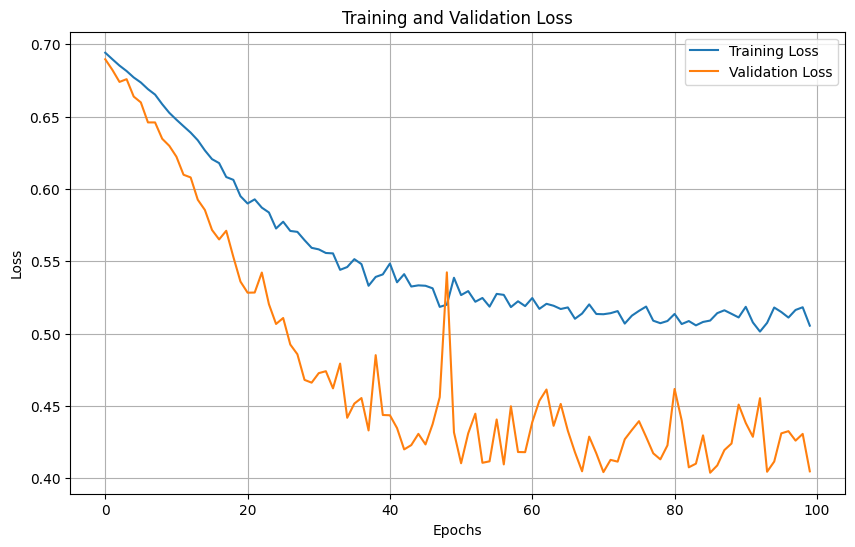

In [10]:
plot_loss(train_losses, val_losses)

In [11]:
# evaluation mode
pytorch_model.eval()
with torch.no_grad():
    y_pred = pytorch_model(X_test_tensor).numpy()
    y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7612
Precision: 0.7273
Recall: 0.7742


# Assingment 3

---



## Instructions:

1. The content that you submit must be your individual work.
2. Submit your code in .py as well as in .ipynb file format. Both these file submissions are required to receive credit for this assignment.
3. Ensure your code is well-commented and easy to follow. You can write your answers and explanations using text cells in the jupyter notebook files wherever required.
4. The files should be named as “(roll_number)_assignment_3”. For example, if your roll number is 23AI91R01, the code file names will be 23AI91R01_assignment_3.py and 23AI91R01_assignment_3.ipynb. You should place all these files within a single .zip file (do not upload a .rar file) and upload it to Moodle as 23AI91R01_assignment_3.zip. The zip file should only contain the .py and .ipynb files, and nothing else.
5. All submissions must be made through Moodle before the deadline. The submission portal will close at the specified time, and submissions via email would not be accepted.
6. The .ipynb file acts as your assignment report in addition to the implementation. Therefore, ensure that the .ipynb file is clear and easy to assess. To discourage plagiarism, the .py file is used to check for plagiarism with very strict deduction criteria. Anyone trying to bypass the plagiarism check with means such as gibberish text inside the code will also experience harsh deduction.
7. The primary TA for assignment 3 is Chhavi Chaudhary (chhavi073@kgpian.iitkgp.ac.in). In case you have any query regarding the assignment, you can email the TA. Please do not call.

**Question 1 (2 marks)**

Dataset Loading and Preprocessing

Load the Communities and Crime dataset from UCI and perform the following tasks:

*   Remove the non-predictive features: state, county, community,  community name and fold.

*   Check the dataset for missing values and duplicate entries.


*  Construct the final feature matrix X and the target vector y suitable for a regression task.



**Question 2 (1 marks)**

Dataset Splitting

Split the preprocessed dataset into the following subsets:
*  Training set: 70%
*  Validation set: 15%
*  Test set: 15%

Ensure that the split is reproducible and clearly report the sizes of each subset.

**Question 3 (5 Marks)**

Neural Network Design from Scratch (NumPy)

Design and implement a feedforward neural network from scratch using NumPy only for a regression task, with the following architecture:

Two hidden layers:

1.  Hidden Layer 1: 32 neurons, ReLU activation
2.  Hidden Layer 2: 16 neurons, ReLU activation

Output layer:

1.  1 neuron, linear activation

Implement weight initialization, forward propagation, backpropagation, and gradient descent-based parameter updates.

**Question 4 (3 Marks)**

Training the Neural Network Using Mini-Batch Gradient Descent with Huber Loss

In this question, you are required to train the feedforward neural network implemented in the previous questions using mini-batch gradient descent.

Your task must satisfy the following requirements:

(i) Use mini-batch gradient descent with a fixed mini-batch size of 32.

(ii) Use the Huber loss function for training.

Train the model for multiple values of the Huber loss hyperparameter 𝛿.
Use the following five values:

𝛿 ∈ {0.1, 0.5, 1.0, 2.0, 5.0}

For each value of 𝛿:

* Train a separate model.  
* Continue training until convergence, where convergence is defined as the point at which the validation loss does not decrease further.
*  Record the training loss and validation loss at each epoch.   
*  Save the trained model weights corresponding to that 𝛿.


Plot the results such that:
* All plots appear in a single figure.  
* Training loss and validation loss are plotted for each 𝛿

The final figure must therefore contain 10 curves in total.

**Question 5 (2 marks)**

Best δ selection Using R² Score

For each value of 𝛿 used in the previous question:

*  Compute the R² score on the validation set.
*  Identify and report the value of 𝛿 that yields the highest validation R² score.


**Question 6 (2 marks)**

Test Set Evaluation and Prediction Visualization

Using the model trained with the best
𝛿:

*  Load the corresponding saved weights
*  Evaluate the model on the test set and report the R² score
*  Plot a scatter plot of predicted values vs. ground truth values for the test set

**Question 7 (3 marks)**

PyTorch Implementation and Comparison

Implement the same neural network model using PyTorch, ensuring that:

* The architecture is identical to the NumPy-based model
* The Huber loss is used with the best
𝛿 obtained earlier
* The model is trained using SGD optimizer
* The mini-batch size (32) and dataset splits remain unchanged

During training:
*  Track training loss and validation loss across epochs
*  Plot the training and validation loss curves on a single figure


**Question 8 (2 marks)**

Using the trained PyTorch model, perform the following tasks:

Compute and report the $R^2$ score of the PyTorch-trained model on the test set.

Generate a prediction vs. ground-truth scatter plot:

* One axis showing the predicted values,
* The other axis showing the true target values,
* Axes and plot title must be clearly labeled.
  

Compare the test-set $R^2$ score obtained using:

* The PyTorch implementation, and
* The from-scratch NumPy-based neural network obtained earlier.
